In [90]:
#import MEDYANSimRunner
using MEDYAN
using MEDYANVis
using StaticArrays
using LinearAlgebra
using Random
using Setfield
using OrderedCollections: OrderedDict
using SmallZarrGroups
using CairoMakie
using ForwardDiff
using SparseArrays
using Statistics

LoadError: ArgumentError: Package Plots not found in current path.
- Run `import Pkg; Pkg.add("Plots")` to install the Plots package.

In [8]:
"Simulation cube length in 500 nm segments."
L = 1

"Number of steps to take."
NSTEPS = 1000

jobs = ["1", "2", "3",]

"""
Return the header_dict and context.
"""
function setup(job::String; kwargs...)
    agentnames = MEDYAN.AgentNames(
        diffusingspeciesnames= [:a,:cl,:m],
        filamentnames= [(:actin,[
                                :plusend,
                                :minusend,
                                :middle,
                                :bound,
                            ]),
        ],
        link_2mon_names= [
            :motor,
            :crosslinker,
        ]
    )
    grid = CubicGrid((L,L,L),500.0)
    monomerspacing = MEDYAN.ACTIN_FIL_PARAMS.spacing
    begin
        s= MEDYAN.SysDef(agentnames)

        add_diffusion_coeff!(s, :a, 20E6)
        add_diffusion_coeff!(s, :cl, 2.0E6)
        add_diffusion_coeff!(s, :m, 0.2E6)

        add_filament_params!(s, 
            :actin,
            MEDYAN.ACTIN_FIL_PARAMS,
        )

        add_link_2mon!(s,
            :motor,
            Link2MonState((numHeads=20,),(L0=NaN,)),
            MEDYAN.DistanceRestraintMechParams(k=55.0),
        )
        
        add_link_2mon!(s,
            :crosslinker,
            Link2MonState((;),(L0=NaN,)),
            MEDYAN.DistanceRestraintMechParams(k=8.0),
        )
        
        #plus end polymerization
        addfilamentend_reaction!(s, :actin, :pp, false,
            [:plusend]=>[:middle,:plusend], monomerspacing,
            "diffusing.a -->", 0.154*500^3, 1,
        )
        #plus end depolymerization
        addfilamentend_reaction!(s, :actin, :dpp, false,
            [:middle,:plusend]=>[:plusend], 0.0,
            "--> diffusing.a", 1.4, 0,
        )

        #minus end polymerization
        addfilamentend_reaction!(s, :actin, :mp, true,
            [:minusend]=>[:minusend,:middle], monomerspacing,
            "diffusing.a -->", 0.0173*500^3, 1,
        )
        #minus end depolymerization
        addfilamentend_reaction!(s, :actin, :dmp, true,
            [:minusend,:middle]=>[:minusend], 0.0,
            "--> diffusing.a", 0.8, 0,
        )

        motorstepsize = 10

        #motor binding
        site = MEDYAN.Decimated2MonSiteMinAngleRange(
            s.filament.actin,
            s.filament.actin,
            motorstepsize,
            motorstepsize,
            s.state.actin.middle,
            s.state.actin.middle,
            175.0,
            225.0,
            cos(5*π/180),
        )
        add_decimated_2mon_site!(s,:motorbinding,site)
        bindcallback = MEDYAN.SimpleMotorBindCallback(
            s.decimated_2mon_site.motorbinding.id,
            s.link_2mon.motor,
            30, #max number of heads
            15, #min number of heads
            s.state.actin.bound,
            [s.diffusing.m=>-1],
        )
        addreactioncallback!(
            s,
            "decimated_2mon_site.motorbinding + diffusing.m",
            0.2*22*500^3/2,
            1,
            bindcallback,
        )

        #motor unbinding
        site = MEDYAN.Link2MonSiteMotorCatch()
        addunbindinglink_2mon_site!(s, 
            :motor, :unbinding, site,
            :actin, :middle, :actin, :middle,
            "--> diffusing.m", 1.0, 0, 
        )

        #motor stepping
        onrate = 0.2
        offrate = 1.7
        dutyratio = onrate/(onrate+offrate)
        site1 = MEDYAN.Link2MonSiteMotorStall(
            fs = 90.0,
            k0 = 6.0/(108/4)*((1 - dutyratio) / dutyratio) * onrate,
            isminusend = true,
        )
        site2 = @set site1.isminusend = false
        add_link_2mon_site!(s,:motor,:motorstepminus,site1)
        add_link_2mon_site!(s,:motor,:motorstepplus,site2)
        stepcallback1 = MEDYAN.SimpleMotorStepCallback(
            lsid = s.link_2mon_site.motor.motorstepminus.id,
            ltid = s.link_2mon.motor,
            unboundstate = s.state.actin.middle,
            boundstate = s.state.actin.bound,
            stepsize = motorstepsize,
        )
        stepcallback2 = @set stepcallback1.lsid = s.link_2mon_site.motor.motorstepplus.id
        addreactioncallback!(
            s,
            "link_2mon_site.motor.motorstepminus",
            1.0,
            0,
            stepcallback1,
        )
        addreactioncallback!(
            s,
            "link_2mon_site.motor.motorstepplus",
            1.0,
            0,
            stepcallback2,
        )

        #crosslinker binding site
        site = MEDYAN.Decimated2MonSiteMinAngleRange(
            s.filament.actin,
            s.filament.actin,
            10,
            10,
            s.state.actin.middle,
            s.state.actin.middle,
            30.0,
            40.0,
            cos(5*π/180)
        )
        add_decimated_2mon_site!(s,:crosslinkbinding,site)
        sitecallback = MEDYAN.SimpleCrosslinkBindCallback(
            s.decimated_2mon_site.crosslinkbinding.id,
            s.link_2mon.crosslinker,
            s.state.actin.bound,
            [s.diffusing.cl=>-1],
        )
        addreactioncallback!(s,
            "decimated_2mon_site.crosslinkbinding + diffusing.cl",
            0.01*500^3/2,
            1,
            sitecallback,
        )

        #crosslinker unbinding
        site = MEDYAN.Link2MonSiteSlipBond(f0 = inv(0.24*MEDYAN.default_β) , k0 = 0.3)
        addunbindinglink_2mon_site!(s, 
            :crosslinker, :unbinding, site,
            :actin, :middle, :actin, :middle,
            "--> diffusing.cl", 1.0, 0, 
        )
    end
    begin
        NMonomers= 40
        monomerstates= zeros(UInt8,NMonomers)
        monomerstates[1:end] .= s.state.actin.middle
        monomerstates[1] = s.state.actin.minusend
        monomerstates[end] = s.state.actin.plusend
    end
    begin
        c= MEDYAN.Context(s,grid;
            g_tol=1.0,
            max_cylinder_force = 1000.0,
            maxstep = 0.7,
        )
        set_mechboundary!(c, MEDYAN.boundary_box(grid; stiffness=100.0))
        adddiffusingcount_rand!(c, s.diffusing.a, 625*L^3)
        adddiffusingcount_rand!(c, s.diffusing.cl, 63*L^3)
        adddiffusingcount_rand!(c, s.diffusing.m, 6*L^3)
        for i in 1:(7*L^3)
            newfilament_rand!(c::MEDYAN.Context, monomerstates)
            MEDYAN.minimize_energy!(c)
        end
    end
    header = OrderedDict([
        "medyan"=>MEDYAN.header(c),
    ])
    return header, c, s
end

"""
Save the context into a group
"""
function save(step::Int, c::MEDYAN.Context; kwargs...)::ZGroup
    group = ZGroup()
    group["medyan"] = MEDYAN.snapshot(c;
        filament_position_scale=5,
        membrane_position_scale=5,
    )
    group
end

"""
Load the context from a group
"""
function load(step::Int, group::ZGroup, c; kwargs...)
    MEDYAN.load_snapshot!(c, group["medyan"]::ZGroup)
    c
end

function done(step::Int, c)
    step ≥ NSTEPS, NSTEPS
end

"""
Move the simulation forward one second in time.
"""
function loop(step::Int, c; kwargs...)
    for j in 1:20
        MEDYAN.run_chemistry!(c,0.05)
        MEDYAN.minimize_energy!(c)
    end
    c
end

loop

In [67]:
"""
Calculates the numerical Hessian.
"""
function Hessian(fc,x0;dx=0.0001)
    d = 0.1 # 1Å displacement
    MEDYAN.refresh_neighborlists!(fc,x0)
    MEDYAN.calc_all_force_energy!(fc, x0)
    x = copy(x0)
    force0 = copy(fc.forces)
    force_pls = zeros(length(x))
    force_min = zeros(length(x))
    energy = fc.energy[]
    hess = zeros(length(x),length(x))
    for i in 1:length(x)
        x .= x0
        x[i] += dx
        MEDYAN.calc_all_force_energy!(fc, x)
        force_pls .= fc.forces
        x .= x0
        x[i] -= dx
        MEDYAN.calc_all_force_energy!(fc, x)
        force_min .= fc.forces
        hess[:,i] .= (force_min .- force_pls)*inv(2*dx)
    end
    hess = 0.5*(hess + hess')
    return energy,force0,hess
end

"""
Calculates the analytical Hessian for testing purposes.
"""
function HessianForwardDiff(E,x)
    energy = E(x)
    force = -ForwardDiff.gradient(E,x)
    hess = ForwardDiff.hessian(E,x)
    return energy,force,hess
end

HessianForwardDiff

In [68]:
"""
Calculates inverse participation ratio for all the modes.
"""
function inv_part_rat(hess)
    hess_evecs = eigvecs(hess)
    rk_all = zeros(size(hess_evecs,1))
    #loop over all eigenvectors of hessian
    for k in 1:size(hess_evecs,1)
        #loop over all components of each eigenvectos
        for i in 1:size(hess_evecs,1) 
             rk_all[k] += (hess_evecs[i,k])^4
        end
        rk_all[k] = inv(rk_all[k])
    end
    return rk_all
end

"""
Calculates the inverse participation ratio, averaged over all modes.
"""
function avg_inv_part_rat(rk_all)
    avg_r = mean(rk_all)
    return avg_r
end

avg_inv_part_rat

In [4]:
vis = Visualizer()
setvisible!(vis["/Grid"], false)
setvisible!(vis["/Axes"], false)
setvisible!(vis["/Background"], false)

[ Info: Listening on: 127.0.0.1:8700, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat Visualizer with path /Background at http://127.0.0.1:8700

In [92]:
#set up system and run
nsec = 1000
nstep_per_sec = 20
dt = 0.05
header,c,s = setup(jobs[1])

t_arr = collect(range(0.0, nstep_per_sec*dt, nsec*nstep_per_sec))
avg_r = zeros(nsec*nstep_per_sec)

k = 1
for i in 1:nsec
    for j in 1:nstep_per_sec
        MEDYAN.run_chemistry!(c,dt)
        #get n-th minimized state
        MEDYAN.minimize_energy!(c)
        
        #calc Hessian
        fc = MEDYAN.ForceContext(c)
        e,f,hess = Hessian(fc,fc.x0;dx=0.0001)
        #calc average inverse participlation ratio
        rk_all = inv_part_rat(hess)
        avg_r[k] = avg_inv_part_rat(rk_all)
        
        #draw_context!(vis, c, s)
        sleep(0.02)
        k += 1
    end
end

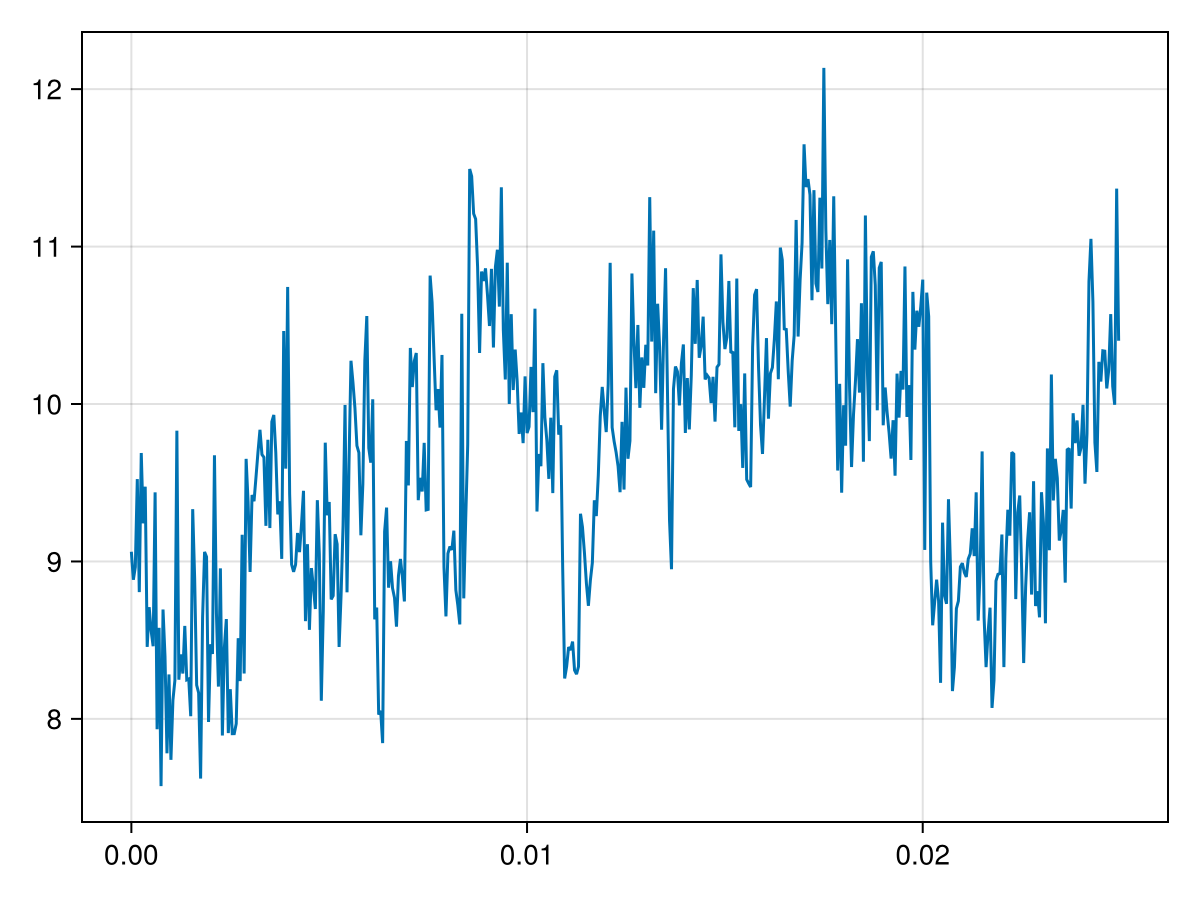

In [100]:
f = Figure()
ax = Axis(f[1, 1])
x = range(0, 10, length=100)
y = sin.(x)
lines!(ax, t_arr[1:500],avg_r[1:500])
f

In [10]:
fc = MEDYAN.ForceContext(c)
e,f,h = Hessian(fc,fc.x0;dx=0.0001)

(0.3819621380537212, [-0.20841822632331322, 0.04311258431042454, -0.017774185437055917, 0.0939013470755183, 0.5378354047397125, -0.24008574834573468, -0.3913456357864592, 0.2674710461540223, 0.07327153685643185, -0.46214352957554006  …  0.15715866371986448, 0.08701035374621298, -0.9132937197518232, -0.16815759761058083, -0.004558698474050344, 0.05440028845848004, 0.010246196337014131, -0.000993033781366227, 0.004788158253859346, 0.0007527375537022313], [264.2555488677137 -194.91842568400477 … 0.0 0.0; -194.91842568400477 145.52225582944368 … 0.0 0.0; … ; 0.0 0.0 … 239.92858295719205 43.79380638717715; 0.0 0.0 … 43.79380638717715 8.365832488390193])

In [11]:
sparse(h)

84×84 SparseMatrixCSC{Float64, Int64} with 1242 stored entries:
⎡⣿⣿⣿⣿⣇⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⣿⣿⣿⣿⣿⡇⠀⠀⢠⣤⣤⡄⠀⠀⠀⠀⠀⠀⢸⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠉⠹⠿⠿⠿⢇⣀⣀⣸⣿⠿⠇⠀⠀⠀⠀⠀⠀⠈⠉⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣤⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⣶⣶⣾⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠿⠿⠇⠀⠿⠿⠿⠿⢇⣀⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣧⣤⠀⢠⣤⣤⡄⠀⠀⢠⣤⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⠿⣿⣿⣿⣿⠀⠸⠿⠿⠇⠀⠀⠸⠿⠿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⠛⠛⠛⣤⣤⣤⣤⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⢰⣶⣶⡆⠀⠀⠀⠀⠀⠀⠀⠀⣶⣶⡆⠀⣿⣿⣿⣿⣷⣶⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠸⠿⠿⠇⠀⠀⠀⠀⠀⠀⠀⠀⠿⠿⠇⠀⠿⢿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠛⠛⠛⠛⣤⣤⣤⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣶⣶⡆⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣶⡆⠀⣀⣀⣀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⠛⠃⠀⠀⠀⠀⠀⠀⠀⠛⢻⣿⣿⣿⡇⠀⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⠉⠉⢱⣶⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠛⠛⠛⠛⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠉⠉⢱⣶⣶⣶⣆⣀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢹⣿⣿⣿⣿⎦

In [12]:
eigvals(h)

84-element Vector{Float64}:
   -0.009374608465262117
   -0.00636263018688022
   -0.004184260592117015
   -0.0035233317891030665
   -0.0033881883131036787
   -0.002288360570760688
   -0.0007233503049207788
   -0.0006910486094766579
   -0.0004894964613627683
   -0.0004109236568423107
   -0.00026726959921918435
   -0.00026690460966827457
   -0.0002669044742739787
    ⋮
  475.9492429484818
  481.2559220637052
  502.35056809468637
  557.5630594604751
  597.0380182205582
  795.4482369516764
  958.760821564698
  996.7633495277986
 1103.5677423689558
 1212.6741167766068
 1655.782103314666
 1665.3374574555774

In [51]:
eigvecs(h)[:,1]

84-element Vector{Float64}:
  0.07496850387230156
  0.04531959659736924
 -0.0013849828576794542
  0.031997885412966595
 -0.009329110709378773
  0.005362373271424984
 -0.15871637884012474
 -0.25345265792547395
  0.03581965083379195
 -0.24876971278588517
 -0.36885347151443576
  0.05023974194450832
 -3.708835967746864e-5
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [ ]:
minimum(diag(h))

In [ ]:
h[1:6,1:6]

In [ ]:
#display.(Hessian(fc,fc.x0;dx=0.0001))